# The Prescott Real Business Cycle DSGE Model 

[![badge](https://img.shields.io/badge/Launch%20using%20-Econ--ARK-blue)](https://econ-ark.org/materials/the-prescott-real-business-cycle-rbc#launch)



This handout presents the elements of the original Real Business Cycle model of
aggregate fluctuations, as laid out by Prescott (1986) and as outlined in Christopher Carroll's lecture notes.__[RBC-Prescott](http://www.econ2.jhu.edu/people/ccarroll/public/LectureNotes/DSGEModels/RBC-Prescott.pdf)__.

This notebook demonstrates how to setup, solve, and estimate a simple real business cycle model in Python. The model is very standard; the setup and notation here corresponds to one seen in Chris Carroll's lecture notes.

The observational results of the Ramey-Francis (2009) are presented in this notebook __[Notebook-Ramey-Francis(2009)](https://github.com/ani1231091/Real-Business-Cycle-)__.

In [ ]:
#Initials
%matplotlib inline
from __future__ import division

import numpy as np
from scipy import optimize, signal
import pandas as pd
from pandas_datareader.data import DataReader
import statsmodels.api as sm
from statsmodels.tools.numdiff import approx_fprime, approx_fprime_cs
from IPython.display import HTML, display
import matplotlib.pyplot as plt

# import seaborn as sn
from numpy.testing import assert_allclose

# Set some pretty-printing options
np.set_printoptions(precision=3, suppress=True, linewidth=120)
pd.set_option('float_format', lambda x: '%.3g' % x, )

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this RBC notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


Some Theory

King, Plosser, and Rebelo (1988) characterize the set of utility functions such that the model admits a Balanced Growth Path.
With labor-augmenting technical progress, and hence ever increasing wages, there are income and substitution effects.
The income and substitution effects cancel each other if and only if
$$u(c_t, z_t) = \log(c_t) + v(z_t) $$ or
$$u(c_t, z_t)=\frac{(c)^(1-\sigma)}{1-\sigma}v(z_t)$$
where v(z)=$\psi$ (1-l), $\psi$ >0, $0\leq l \leq 1$.


## Household problem

$$
\max E_0 \sum_{t=0}^\infty \beta^t u(c_t, z_t)
$$

s.t:

- the budget constraint: $y_t = c_t + i_t$
- the capital accumulation equation: $k_{t+1} = (1 - \delta) k_t + i_t$
- $1 = l_t + z_t$

where households have the following production technology:

$$y_t = a_t f(k_t, l_t)$$

and where the (log of the) technology process follows an AR(1) process:

$$
\log a_t = \rho \log a_{t-1} + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma^2)
$$

## Functional forms

We will assume additively separable utility in consumption and leisure (Prescott 1986,King-Rebello-Plosser 1988), with:

$$u(c_t, z_t) = \log(c_t) + v(z_t) $$

where v(z)=$\psi$ (1-l), $\psi$ >0, $0\leq l \leq 1$.

The production function will be Cobb-Douglas:

$$f(k_t, l_t) = k_t^\alpha l_t^{1 - \alpha}$$
where $\alpha$ is the marginal product of capital. Later for simulation and calibration purposes, we ll place a value on $\alpha$.

## FOC Solving

Two equations characterize the FOC for the infinite time horizon. The first one for choosing between leisure and consumption, the second one is the classic euler equation for consumption.

$$
\begin{align}
\psi & = \frac{1}{c_t} (1 - \alpha) a_t \left ( \frac{k_t}{l_t} \right )^{\alpha} & \text{Consumption-Leisure Choice} \\
\frac{1}{c_t} & = \beta E_t \left \{ \frac{1}{c_{t+1}} \left [ \alpha a_{t+1} \left ( \frac{k_{t+1}}{l_{t+1}} \right )^{\alpha - 1} + (1 - \delta) \right ] \right \} & \text{Euler Equation for Consumption} \\
\end{align}
$$

## Equations characterizing the system

Collecting all of the model equations, we have:

$$
\begin{align}
\psi c_t & = (1 - \alpha) a_t \left ( \frac{k_t}{l_t} \right )^{\alpha} & \text{Static FOC} \\
\frac{1}{c_t} & = \beta E_t \left \{ \frac{1}{c_{t+1}} \left [ \alpha a_{t+1} \left ( \frac{k_{t+1}}{l_{t+1}} \right )^{\alpha - 1} + (1 - \delta) \right ] \right \} & \text{Euler equation} \\
y_t & = a_t k_t^\alpha l_t^{1 - \alpha} & \text{Production function} \\
y_t & = c_t + i_t & \text{Aggregate resource constraint} \\
k_{t+1} & = (1 - \delta) k_t + i_t & \text{Captial accumulation} \\
y_t & = c_t + k_{t+1}-(1 - \delta) k_t & \text{The combined resource constraint}\\
1 & = l_t + z_t & \text{Labor-leisure tradeoff} \\
\log a_t & = \rho \log a_{t-1} + \varepsilon_t & \text{Technology shock transition}
\end{align}
$$

### Variables / Parameters

At this point, it becomes important to distinguish between the different types of variables that are involved in these equations. Jumpers and ...
This system is in the following variables:

$$
\begin{align}
x_t = \{ \quad & &\\
& y_t, & \text{Output}\\
& c_t, & \text{Consumption}\\
& i_t, & \text{Investment}\\
& l_t, & \text{Labor}\\
& z_t, & \text{Leisure}\\
& k_t, & \text{Capital}\\
& a_t  & \text{Technology} \\
\} \quad & &
\end{align}$$

and depends on the following parameters:

$$
\begin{align}
\{ \quad & &\\
& \beta, & \text{Discount rate}\\
& \psi, & \text{Marginal disutility of labor}\\
& \delta, & \text{Depreciation rate}\\
& \alpha, & \text{Capital-share of output}\\
& \rho, & \text{Technology shock persistence}\\
& \sigma^2 & \text{Technology shock variance}\\
\} \quad & &
\end{align}$$

In [2]:
# Save the names of the equations, variables, and parameters
equation_names = [
    'static FOC', 'euler equation', 'production',
    'aggregate resource constraint', 'capital accumulation',
    'labor-leisure', 'technology shock transition'
]
variable_names = [
    'output', 'consumption', 'investment',
    'labor', 'leisure', 'capital', 'technology'
]
parameter_names = [
    'discount rate', 'marginal disutility of labor',
    'depreciation rate', 'capital share',
    'technology shock persistence',
    'technology shock standard deviation',
]

# Save some symbolic forms for pretty-printing
variable_symbols = [
    r"y", r"c", r"i", r"l", r"z", r"k", r"a",
]
contemporaneous_variable_symbols = [
    r"$%s_t$" % symbol for symbol in variable_symbols
]
lead_variable_symbols = [
    r"$%s_{t+1}$" % symbol for symbol in variable_symbols
]

parameter_symbols = [
    r"$\beta$", r"$\psi$", r"$\delta$", r"$\alpha$", r"$\rho$", r"$\sigma^2$"
]

## Numerical method

Using these equations, we can numerically find the steady-state using a root-finding algorithm and can then log-linearize around the steady-state using a numerical gradient procedure. In particular, here we follow DeJong and Dave (2011) chapter 2 and 3.1.

Write the generic non-linear system as:

$$
\Gamma(E_t x_{t+1}, x_t, z_t) = 0
$$

in the absense of shocks, this can be rewritten as:

$$
\Psi(x_{t+1}, x_t) = 0
$$

or as:

$$
\Psi_1(x_{t+1}, x_t) = \Psi_2(x_{t+1}, x_t)
$$

and finally in logs as

$$
\log \Psi_1(e^{\log x_{t+1}}, e^{\log x_t}) - \log \Psi_2(e^{\log x_{t+1}}, e^{\log x_t}) = 0
$$

First, we define a new class (`RBC1`) which holds the state of the RBC model (its dimensions, parameters, etc) and has methods for evaluating the log system. The `eval_logged` method evaluates the last equation, above.

Notice that the order of variables and order of equations is as described above.

In [3]:
class RBC1(object):
    def __init__(self, params=None):
        # Model dimensions
        self.k_params = 6
        self.k_variables = 7
        
        # Initialize parameters
        if params is not None:
            self.update(params)
    
    def update(self, params):
        # Save deep parameters
        self.discount_rate = params[0]
        self.disutility_labor = params[1]
        self.depreciation_rate = params[2]
        self.capital_share = params[3]
        self.technology_shock_persistence = params[4]
        self.technology_shock_std = params[5]
        
    def eval_logged(self, log_lead, log_contemporaneous):
        (log_lead_output, log_lead_consumption, log_lead_investment,
         log_lead_labor, log_lead_leisure, log_lead_capital,
         log_lead_technology_shock) = log_lead
        
        (log_output, log_consumption, log_investment, log_labor,
         log_leisure, log_capital, log_technology_shock) = log_contemporaneous
        
        return np.r_[
            self.log_static_foc(
                log_lead_consumption, log_lead_labor,
                log_lead_capital, log_lead_technology_shock
            ),
            self.log_euler_equation(
                log_lead_consumption, log_lead_labor,
                log_lead_capital, log_lead_technology_shock,
                log_consumption
            ),
            self.log_production(
                log_lead_output, log_lead_labor, log_lead_capital,
                log_lead_technology_shock
            ),
            self.log_aggregate_resource_constraint(
                log_lead_output, log_lead_consumption,
                log_lead_investment
            ),
            self.log_capital_accumulation(
                log_lead_capital, log_investment, log_capital
            ),
            self.log_labor_leisure_constraint(
                log_lead_labor, log_lead_leisure
            ),
            self.log_technology_shock_transition(
                log_lead_technology_shock, log_technology_shock
            )
        ]
    
    def log_static_foc(self, log_lead_consumption, log_lead_labor,
                       log_lead_capital, log_lead_technology_shock):
        return (
            np.log(self.disutility_labor) +
            log_lead_consumption -
            np.log(1 - self.capital_share) -
            log_lead_technology_shock -
            self.capital_share * (log_lead_capital - log_lead_labor)
        )
        
    def log_euler_equation(self, log_lead_consumption, log_lead_labor,
                           log_lead_capital, log_lead_technology_shock,
                           log_consumption):
        return (
            -log_consumption -
            np.log(self.discount_rate) +
            log_lead_consumption -
            np.log(
                (self.capital_share *
                 np.exp(log_lead_technology_shock) * 
                 np.exp((1 - self.capital_share) * log_lead_labor) /
                 np.exp((1 - self.capital_share) * log_lead_capital)) +
                (1 - self.depreciation_rate)
            )
        )
        
    def log_production(self, log_lead_output, log_lead_labor, log_lead_capital,
                       log_lead_technology_shock):
        return (
            log_lead_output -
            log_lead_technology_shock -
            self.capital_share * log_lead_capital -
            (1 - self.capital_share) * log_lead_labor
        )
        
    def log_aggregate_resource_constraint(self, log_lead_output, log_lead_consumption,
                                          log_lead_investment):
        return (
            log_lead_output -
            np.log(np.exp(log_lead_consumption) + np.exp(log_lead_investment))
        )
    
    def log_capital_accumulation(self, log_lead_capital, log_investment, log_capital):
        return (
            log_lead_capital -
            np.log(np.exp(log_investment) + (1 - self.depreciation_rate) * np.exp(log_capital))
        )
    
    def log_labor_leisure_constraint(self, log_lead_labor, log_lead_leisure):
        return (
            -np.log(np.exp(log_lead_labor) + np.exp(log_lead_leisure))
        )
    
    def log_technology_shock_transition(self, log_lead_technology_shock, log_technology_shock):
        return (
            log_lead_technology_shock -
            self.technology_shock_persistence * log_technology_shock
        )

Later we will estimate (some of) the parameters; in the meantime we fix them at the values used to generate the datasets.

In [4]:
# Setup fixed parameters
parameters = pd.DataFrame({
    'name': parameter_names,
    'value': [0.95, 3, 0.025, 0.36, 0.85, 0.76]
})
parameters.T

,0,1,2,3,4,5
name,discount rate,marginal disutility of labor,depreciation rate,capital share,technology shock persistence,technology shock standard deviation
value,0.95,3,0.025,0.36,0.85,0.76


## Steady state

### Numeric calculation

To numerically calculate steady-state, we apply a root-finding algorithm to the `eval_logged` method. In particular, we are finding values $\bar x$ such that

$$\log \Psi_1(e^{\log \bar x}, e^{\log \bar x}) - \log \Psi_2(e^{\log \bar x}, e^{\log \bar x}) = 0$$

These will be confirmed analytically, below.

Here we create a derived class, `RBC2` which extends all of the functionality from above, but now includes methods for numerical calcualtion of the steady-state.

In [5]:
class RBC2(RBC1):
    def steady_state_numeric(self):
        # Setup starting parameters
        log_start_vars = [0.5] * self.k_variables  # very arbitrary

        # Setup the function the evaluate
        eval_logged = lambda log_vars: self.eval_logged(log_vars, log_vars)

        # Apply the root-finding algorithm
        result = optimize.root(eval_logged, log_start_vars)
        
        return np.exp(result.x)

mod2 = RBC2(parameters['value'])

steady_state = pd.DataFrame({
    'value': mod2.steady_state_numeric()
}, index=variable_names)

steady_state.T

,output,consumption,investment,labor,leisure,capital,technology
value,0.572,0.506,0.0663,0.241,0.759,2.65,1


### Analytic evaluation

In this case, we can analytically evaluate the steady-state:

$$
\begin{align}
\frac{\bar y}{\bar n} & = \eta \\
\frac{\bar c}{\bar n} & = \eta - \delta \theta \\
\frac{\bar i}{\bar n} & = \delta \theta \\
\bar n & = \frac{1}{\left ( \frac{1}{1 - \alpha} \right ) \psi \left [ 1 - \delta \theta^{1-\alpha} \right ]} \\
\bar l & = 1 - \bar n \\
\frac{\bar k}{\bar n} & = \theta
\end{align}
$$

where
$$
\begin{align}
\theta & = \left ( \frac{\alpha}{1/\beta - (1 - \delta)} \right )^\frac{1}{1-\alpha} \\
\eta & = \theta^\alpha
\end{align}
$$

In [6]:
class RBC3(RBC2):
    
    def update(self, params):
        # Update the deep parameters
        super(RBC3, self).update(params)
        
        # And now also calculate some intermediate parameters
        self.theta = (self.capital_share / (
            1 / self.discount_rate -
            (1 - self.depreciation_rate)
        ))**(1 / (1 - self.capital_share))
        
        self.eta = self.theta**self.capital_share
    
    def steady_state_analytic(self):
        steady_state = np.zeros(7)

        # Labor (must be computed first)
        numer = (1 - self.capital_share) / self.disutility_labor
        denom = (1 - self.depreciation_rate * self.theta**(1 - self.capital_share))
        steady_state[3] = numer / denom
        # Output
        steady_state[0] = self.eta * steady_state[3]
        # Consumption
        steady_state[1] = (1 - self.capital_share) * self.eta / self.disutility_labor
        # Investment
        steady_state[2] = self.depreciation_rate * self.theta * steady_state[3]
        # Labor (computed already)
        # Leisure
        steady_state[4] = 1 - steady_state[3]
        # Capital
        steady_state[5] = self.theta * steady_state[3]
        # Technology shock
        steady_state[6] = 1
        
        return steady_state
    
mod3 = RBC3(parameters['value'])

steady_state = pd.DataFrame({
    'numeric': mod3.steady_state_numeric(),
    'analytic': mod3.steady_state_analytic()
}, index=variable_names)

steady_state.T

,output,consumption,investment,labor,leisure,capital,technology
numeric,0.572,0.506,0.0663,0.241,0.759,2.65,1
analytic,0.572,0.506,0.0663,0.241,0.759,2.65,1


## Log-linearization

The system we wrote down, above, was non-linear. In order to estimate it, we want to get it in a linear form:

$$
A E_t \tilde x_{t+1} = B \tilde x_{t} + C v_{t+1}
$$

where $v_{t+1}$ contains structural shocks (here, $z_t$ is included in the $x_t$ vector, and the only structural shock is $\varepsilon_t$, the innovation to $z_t$).

This can be achieved via log-linearization around the steady state. In this case, DeJong and Dave (2011) show that:

$$
A = \left [ \frac{\partial \log [ \Psi_1 ]}{\partial \log(x_{t+1})} (\bar x) - \frac{\partial \log [ \Psi_2 ]}{\partial \log(x_{t+1})} (\bar x) \right ] \\
B = - \left [ \frac{\partial \log [ \Psi_1 ]}{\partial \log(x_t)} (\bar x) - \frac{\partial \log [ \Psi_2 ]}{\partial \log(x_t)} (\bar x) \right ] \\
$$

where $\tilde x_t = \log \left ( \frac{x_t}{\bar x} \right )$ expresses the variables in proportional deviation from steady-state form.

The matrix $C$ can be constructed by observation. In this case, we have:

$$
C = \begin{bmatrix} 0 & 0 & 0 & 0 & 0 & 0 & 1 \end{bmatrix} \qquad \text{and} \qquad v_{t+1} \equiv \varepsilon_t
$$

### Numeric calculation

Since the `eval_logged` method of our class evaluates $\log \Psi_1(e^{\log x_{t+1}}, e^{\log x_t}) - \log \Psi_2(e^{\log x_{t+1}}, e^{\log x_t})$, we can apply a numerical gradient procedure to it to get $A$, when we differentiate with respect to the lead variables, and $B$, when we differentiate with respect to the contemporaneous variables.

To learn about the numerical gradient procedure, one can check out the link __[here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html)__.

In [7]:
class RBC4(RBC3):
    
    def A_numeric(self):
        log_steady_state = np.log(self.steady_state_analytic())

        eval_logged_lead = lambda log_lead: self.eval_logged(log_lead, log_steady_state)
        
        return approx_fprime_cs(log_steady_state, eval_logged_lead)

    def B_numeric(self):
        log_steady_state = np.log(self.steady_state_analytic())
        
        eval_logged_contemporaneous = lambda log_contemp: self.eval_logged(log_steady_state, log_contemp)
        
        return -approx_fprime_cs(log_steady_state, eval_logged_contemporaneous)
    
    def C(self):
        return np.r_[[0]*(self.k_variables-1), 1]

mod4 = RBC4(parameters['value'])
        
display(pd.DataFrame(mod4.A_numeric(), index=equation_names, columns=lead_variable_symbols))
display(pd.DataFrame(mod4.B_numeric(), index=equation_names, columns=contemporaneous_variable_symbols))
display(pd.DataFrame(mod4.C(), index=equation_names, columns=[r'$\varepsilon_t$']))

,$y_{t+1}$,$c_{t+1}$,$i_{t+1}$,$l_{t+1}$,$z_{t+1}$,$k_{t+1}$,$a_{t+1}$
static FOC,0,1,0,0.36,0,-0.36,-1
euler equation,0,1,0,-0.0472,0,0.0472,-0.0737
production,1,0,0,-0.64,0,-0.36,-1
aggregate resource constraint,1,-0.884,-0.116,0,0,0,0
capital accumulation,0,0,0,0,0,1,0
labor-leisure,-0,-0,-0,-0.241,-0.759,-0,-0
technology shock transition,0,0,0,0,0,0,1


,$y_t$,$c_t$,$i_t$,$l_t$,$z_t$,$k_t$,$a_t$
static FOC,-0,-0,-0,-0,-0,-0,-0
euler equation,-0,1,-0,-0,-0,-0,-0
production,-0,-0,-0,-0,-0,-0,-0
aggregate resource constraint,-0,-0,-0,-0,-0,-0,-0
capital accumulation,-0,-0,0.025,-0,-0,0.975,-0
labor-leisure,-0,-0,-0,-0,-0,-0,-0
technology shock transition,-0,-0,-0,-0,-0,-0,0.85


,$\varepsilon_t$
static FOC,0
euler equation,0
production,0
aggregate resource constraint,0
capital accumulation,0
labor-leisure,0
technology shock transition,1


### Analytic evaluation

This system can be log-linearized directly, as well, yielding (see e.g. Ruge-Murcia (2007) Appendix A for these formulas, with slightly different notation):

$$
\begin{align}
\tilde c_t & = \tilde z_t + \alpha \tilde k_t - \alpha \tilde n_t \\
-\tilde c_t & = -E_t \tilde c_{t+1} + \zeta (\alpha - 1) E_t \tilde k_{t+1} + \zeta (1 - \alpha) E_t \tilde n_{t+1} + \zeta E_t \tilde z_{t+1} \\
\tilde y_t & = \tilde z_t + \alpha \tilde k_t + (1 - \alpha) \tilde n_t \\
\tilde y_t & = \gamma \tilde c_t + (1 - \gamma) \tilde i_t \\
\tilde k_{t+1} & = (1 - \delta) \tilde k_t + \delta \tilde i_t \\
0 & = \frac{\bar l}{\bar l + \bar n} \tilde l_{t+1} + \frac{\bar n}{\bar l + \bar n} \tilde n_{t+1} \\
\tilde z_{t+1} & = \rho \tilde z_t + \varepsilon_t
\end{align}
$$

where $\zeta = \alpha \beta \theta^{\alpha - 1}$ and $\gamma = 1 - \delta \theta^{1 - \alpha}$ is the steady-state consumption-output ratio.

In [8]:
class RBC5(RBC4):
    
    def update(self, params):
        super(RBC5, self).update(params)
        
        # Now calculate some more intermediate parameters
        self.gamma = 1 - self.depreciation_rate * self.theta**(1 - self.capital_share)
        self.zeta = self.capital_share * self.discount_rate * self.theta**(self.capital_share - 1)
    
    def A_analytic(self):
        steady_state = self.steady_state_analytic()
        
        A = np.array([
            [0, 1, 0, self.capital_share, 0, -self.capital_share, -1],
            [0, 1, 0, self.zeta * (self.capital_share - 1), 0, self.zeta * (1 - self.capital_share), -self.zeta],
            [1, 0, 0, (self.capital_share - 1), 0, -self.capital_share, -1],
            [1, -self.gamma, (self.gamma - 1), 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, -steady_state[3], -steady_state[4], 0, 0],
            [0, 0, 0, 0, 0, 0, 1],
        ])
        
        return A

    def B_analytic(self):
        
        B = np.array([
            [0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, self.depreciation_rate, 0, 0, 1 - self.depreciation_rate, 0],
            [0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, self.technology_shock_persistence],
        ])
        
        return B

mod5 = RBC5(parameters['value'])

display(pd.DataFrame(mod5.A_analytic(), index=equation_names, columns=lead_variable_symbols))
assert(np.all(np.abs(mod5.A_numeric() - mod5.A_analytic()) < 1e-10))

display(pd.DataFrame(mod5.B_analytic(), index=equation_names, columns=lead_variable_symbols))
assert(np.all(np.abs(mod5.B_numeric() - mod5.B_analytic()) < 1e-10))

,$y_{t+1}$,$c_{t+1}$,$i_{t+1}$,$l_{t+1}$,$z_{t+1}$,$k_{t+1}$,$a_{t+1}$
static FOC,0,1,0,0.36,0,-0.36,-1
euler equation,0,1,0,-0.0472,0,0.0472,-0.0737
production,1,0,0,-0.64,0,-0.36,-1
aggregate resource constraint,1,-0.884,-0.116,0,0,0,0
capital accumulation,0,0,0,0,0,1,0
labor-leisure,0,0,0,-0.241,-0.759,0,0
technology shock transition,0,0,0,0,0,0,1


,$y_{t+1}$,$c_{t+1}$,$i_{t+1}$,$l_{t+1}$,$z_{t+1}$,$k_{t+1}$,$a_{t+1}$
static FOC,0,0,0,0,0,0,0
euler equation,0,1,0,0,0,0,0
production,0,0,0,0,0,0,0
aggregate resource constraint,0,0,0,0,0,0,0
capital accumulation,0,0,0.025,0,0,0.975,0
labor-leisure,0,0,0,0,0,0,0
technology shock transition,0,0,0,0,0,0,0.85


## System reduction

The system currently has 7 equations in 7 unknowns. This can be reduced into a system of 3 equations in 3 unknowns (consumption, capital, and the technology shock), by substituting out output, investment, labor, and leisure. Given a solution to the reduced system, the remaining four unknowns can be calculated. Also, we remove the technology shock transition from the state vector and include it instead in the stochastic shocks component $(v_{t+1})$. (Jumpers: I may explain here more?. Blanchard Kahn)

First, notice that (using the static first order condition, production function, aggregate resource constraint, and labor-leisure tradeoff equations, respectively):

$$
\begin{align}
\tilde n_t & = - \frac{1}{\alpha} \tilde c_t + \frac{1}{\alpha} \tilde z_t + \tilde k_t \\
\tilde y_t & = \tilde z_t + \alpha \tilde k_t + (1 - \alpha) \left [ - \frac{1}{\alpha} \tilde c_t + \frac{1}{\alpha} \tilde z_t + \tilde k_t \right ] \\
& = \frac{1}{\alpha} \tilde z_t - \frac{1 - \alpha}{\alpha} \tilde c_t + \tilde k_t \\
\tilde i_t & = \frac{1}{1 - \gamma} \left [ \frac{1}{\alpha} \tilde z_t - \frac{1 - \alpha}{\alpha} \tilde c_t + \tilde k_t - \gamma \tilde c_t \right ] \\
& = \frac{1}{1 - \gamma} \left [ \frac{1}{\alpha} \tilde z_t - \frac{1 - \alpha + \gamma \alpha}{\alpha} \tilde c_t + \tilde k_t \right ] \\
\tilde l_t & = - \frac{\bar n}{1 - \bar n} \tilde n_t
\end{align}
$$

then we can plug these values into the remaining three equations (Euler, capital accumulation, and shock transition equations):

$$
\begin{align}
k_{t+1} & = (1 - \delta) \tilde k_t + \delta \frac{1}{1 - \gamma} \left [ \frac{1}{\alpha} \tilde z_t - \frac{1 - \alpha + \gamma \alpha}{\alpha} \tilde c_t + \tilde k_t \right ] \\
& = \underbrace{\left [ 1 + \delta \left ( \frac{\gamma}{1 - \gamma} \right ) \right ]}_{B_{11}, F_{11}} \tilde k_t + \underbrace{\frac{-\delta (1 - \alpha + \gamma \alpha)}{\alpha (1 - \gamma)}}_{B_{12}, F_{12}} \tilde c_t + \underbrace{\frac{\delta}{\alpha (1 - \gamma)}}_{C_1, G_{12}} \tilde z_t
\end{align}
$$

and

$$
\begin{align}
E_t \tilde c_{t+1} & = \tilde c_t + \zeta (\alpha - 1) E_t k_{t+1} + \zeta (1 - \alpha) E_t \left [ - \frac{1}{\alpha} \tilde c_{t+1} + \frac{1}{\alpha} \tilde z_{t+1} + \tilde k_{t+1} \right ] + \zeta E_t \tilde z_{t+1} \\
& = \tilde c_t + \zeta (\alpha - 1) E_t \tilde k_{t+1} - \zeta \frac{(1 - \alpha)}{\alpha} E_t \tilde c_{t+1} + \zeta \frac{(1 - \alpha)}{\alpha} E_t z_{t+1} + \zeta (1 - \alpha) E_t \tilde k_{t+1} + \zeta E_t \tilde z_{t+1} \\
& = \underbrace{\frac{\alpha}{\zeta + \alpha (1 - \zeta)}}_{B_{22}} \tilde c_t + \underbrace{\frac{\zeta \rho}{\zeta + \alpha (1 - \zeta )}}_{C_2} \tilde z_t
\end{align}
$$

and

$$
\begin{align}
\tilde z_{t+1} & = \rho \tilde z_t + \varepsilon_t
\end{align}
$$


In [9]:
# Save the names of the equations, variables, and parameters
# in the reduced model
reduced_equation_names = [
    'euler equation', 'capital accumulation'
]
reduced_variable_names = [
    'consumption', 'capital'
]
reduced_parameter_names = parameter_names

# Save some symbolic forms for pretty-printing
reduced_variable_symbols = [
    r"c", r"k"
]
reduced_contemporaneous_variable_symbols = [
    r"$%s_t$" % symbol for symbol in reduced_variable_symbols
]
reduced_lead_variable_symbols = [
    r"$%s_{t+1}$" % symbol for symbol in reduced_variable_symbols
]

reduced_parameter_symbols = parameter_symbols

In [10]:
class ReducedRBC1(RBC5):
    def __init__(self, params=None):
        # Model dimensions
        self.k_params = 6
        self.k_variables = 2
        
        # Index for the reduced form variables
        self.reduced_idx = [1, -2]
        
        # Initialize parameters
        if params is not None:
            self.update(params)

    def steady_state_numeric(self):
        return super(ReducedRBC1, self).steady_state_numeric()[self.reduced_idx]
        
    def steady_state_analytic(self):
        return super(ReducedRBC1, self).steady_state_analytic()[self.reduced_idx]
    
    def A(self):
        return np.eye(self.k_variables)
    
    def B(self):
        B11 = 1 + self.depreciation_rate * (self.gamma / (1 - self.gamma))
        B12 = (
            -self.depreciation_rate *
            (1 - self.capital_share + self.gamma * self.capital_share) /
            (self.capital_share * (1 - self.gamma))
        )
        B21 = 0
        B22 = self.capital_share / (self.zeta + self.capital_share*(1 - self.zeta))
        
        return np.array([[B11, B12],
                         [B21, B22]])
        
    def C(self):
        C1 = self.depreciation_rate / (self.capital_share * (1 - self.gamma))
        C2 = (
            self.zeta * self.technology_shock_persistence /
            (self.zeta + self.capital_share*(1 - self.zeta))
        )
        return np.array([C1, C2])[:,np.newaxis]
        
# Setup the model
reduced_mod1 = ReducedRBC1(parameters['value'])

# Display the steady-states
reduced_steady_state = pd.DataFrame({
    'steady state': reduced_mod1.steady_state_analytic()
}, index=reduced_variable_names)
display(reduced_steady_state.T)

# Test the model coefficients for accuracy
# (results from "Emsm", downloaded from
# https://sites.google.com/site/frugemurcia/home/replication-files
# on 06/19/2015)
assert_allclose(
    reduced_mod1.B(),
    np.array([[1.1906433, -0.57400910],
              [0,          0.88408644]])
)
assert_allclose(
    reduced_mod1.C(),
    np.array([[0.59900910], [0.15394769]])
)

# Display the linear model coefficients
display(pd.DataFrame(reduced_mod1.A(), index=reduced_equation_names, columns=reduced_lead_variable_symbols))
display(pd.DataFrame(reduced_mod1.B(), index=reduced_equation_names, columns=reduced_contemporaneous_variable_symbols))
display(pd.DataFrame(reduced_mod1.C(), index=reduced_equation_names, columns=[r'$z_t$']))
    

,consumption,capital
steady state,0.506,2.65


,$c_{t+1}$,$k_{t+1}$
euler equation,1,0
capital accumulation,0,1


,$c_t$,$k_t$
euler equation,1.19,-0.574
capital accumulation,0,0.884


,$z_t$
euler equation,0.599
capital accumulation,0.154


## Solving the model

This model can be solved using the method of Blanchard-Kahn (1980). First we put it in the required form:

$$
\begin{bmatrix}
\tilde k_{t+1} \\
E_t \tilde c_{t+1}
\end{bmatrix} = \begin{bmatrix}
B_{11} & B_{12} \\
B_{21} & B_{22}
\end{bmatrix} \begin{bmatrix}
\tilde k_{t} \\
\tilde c_{t} \\
\end{bmatrix} + \begin{bmatrix}
C_{1} \\
C_{2}
\end{bmatrix} \tilde z_t
$$

and the solution yields the following equilibrium dynamics:

$$
\begin{bmatrix}
\tilde k_{t+1} \\
\tilde c_{t+1}
\end{bmatrix} = \begin{bmatrix}
F_{11} & F_{12} \\
F_{21} & F_{22}
\end{bmatrix} \begin{bmatrix}
\tilde k_{t} \\
\tilde c_{t}
\end{bmatrix} + \begin{bmatrix}
G_{11} & G_{12} \\
G_{21} & G_{22}
\end{bmatrix} \begin{bmatrix}
\tilde z_{t+1} \\
\tilde z_t
\end{bmatrix}
$$

in particular, we will find a policy function for the control variable, where the optimal choice for $\tilde c_t$ depends only on the contemporaneous state variable $\tilde k_t$ and exogenous shock $\tilde z_t$. Then the policy expression can be substituted in to the reduced form capital accumulation equation, providing the evolution of the state variable in terms only of itself and the exogenous shock. The evolution of the exogenous shock is an $AR(1)$ as described above.

$$
\begin{align}
\tilde c_t & = \phi_{ck} \tilde k_t + \phi_{cz} \tilde z_t \\
\tilde k_{t+1} & = \underbrace{\left [ F_{11} + F_{12} \phi_{ck} \right ]}_{T_{kk}} \tilde k_t + \underbrace{\left [G_{12} + F_{12} \phi_{cz} \right ]}_{T_{kz}} \tilde z_t \\
\tilde z_{t+1} & = \rho \tilde z_t + \varepsilon_t \\
\end{align}
$$

where $F_{11}, F_{12},$ and $G_{12}$ are defined above (and we have $G_{11} = 0$), and $\phi_{ck}, \phi_{cz}$ are generated by the solution method. $F_{21}, F_{22}, G_{21}, G_{22}$ will not be required for estimation, but can be found by forwarding the equation for $c_t$ and plugging in for $k_{t+1}$.

### Some solution details
Write the Jordan decomposition of $\mathbf{B}$ as:

$$\mathbf{B} = \Lambda^{-1} J \Lambda$$

where

$$
\Lambda = \begin{bmatrix}
\Lambda_{11} & \Lambda_{12} \\
\Lambda_{21} & \Lambda_{22} \\
\end{bmatrix}
\qquad 
J = \begin{bmatrix}
J_1 & 0 \\
0 & J_2 \\
\end{bmatrix}
$$

and we assume that the eigenvalues have been re-ordered so that the explosive ones are contained in $J_2$. Note that to solve the system using the Blanchard-Kahn method, we need to separate the variables into predetermined and non-predetermined. For a unique solution to exist, it must be that the number of non-predetermined variables is equal to the number of explosive eigenvalues (so that we have "saddle-path" stability).

Here, $k_{t+1}$ is predetermined, and $c_{t+1}$ is non-predetermined, so we have a unique solution if there is one explosive eigenvalue and one non-explosive eigenvalue.

Finally we can express the coefficients in the policy function above, as (see for example DeJong and Dave, section 4.3):

$$
\begin{align}
\phi_{ck} & = - \Lambda_{22}^{-1} \Lambda_{21}\\
\phi_{cz} & = - \Lambda_{22}^{-1} J_2^{-1} \left (I - \rho J_2^{-1} D_2 \right )^{-1} \\
\end{align}
$$

where $D_2$ is the lower component of $D = \Lambda \mathbf{C}$. Here, $D_2 = \Lambda_{21} C_1 + \Lambda_{22} C_2$

In [11]:
def ordered_jordan_decomposition(matrix):
    # Get eigenvalues and left eigenvectors of `matrix`
    # Note that the left eigenvectors of `matrix`
    # are the transpose of the right eigenvectors of the
    # transpose of matrix, and that `matrix` and `matrix'`
    # have the same eigenvalues
    eigenvalues, right_eigenvectors = np.linalg.eig(matrix.transpose())
    left_eigenvectors = right_eigenvectors.transpose()
    
    # Sort in increasing order
    idx = np.argsort(eigenvalues)
    
    # Return eigenvector matrix, diagonal eigenvalue matrix
    # Note that the left eigenvectors are in the rows now,
    # not the columns
    return np.diag(eigenvalues[idx]), left_eigenvectors[idx, :]

def solve_blanchard_kahn(B, C, rho, k_predetermined):
    # Perform the Jordan decomposition
    # this yields J, Lambda
    eigenvalues, left_eigenvectors = ordered_jordan_decomposition(B)
    left_eigenvectors = left_eigenvectors

    # Dimensions
    k_variables = len(B)
    k_nonpredetermined = k_variables - k_predetermined

    k_stable = len(np.where(eigenvalues.diagonal() < 1)[0])
    k_unstable = k_variables - k_stable

    # Make sure we're saddle-path stable
    if not k_unstable == k_nonpredetermined:
        raise RuntimeError('Blanchard-Kahn condition not met. Unique solution does not exist')

    # Decouple the system (this is D, above)
    decoupled_C = np.dot(left_eigenvectors, C)

    # Create partition indices
    p1 = np.s_[:k_predetermined]
    p2 = np.s_[k_predetermined:]

    p11 = np.s_[:k_predetermined, :k_predetermined]
    p12 = np.s_[:k_predetermined, k_predetermined:]
    p21 = np.s_[k_predetermined:, :k_predetermined]
    p22 = np.s_[k_predetermined:, k_predetermined:]

    # Solve the explosive component (controls) in terms of the
    # non-explosive component (states) and shocks
    tmp = np.linalg.inv(left_eigenvectors[p22])
    
    # This is \phi_{ck}, above
    policy_state = - np.dot(tmp, left_eigenvectors[p21])
    # This is \phi_{cz}, above
    policy_shock = -(
        np.dot(tmp, 1. / eigenvalues[p22]).dot(
            np.linalg.inv(
                np.eye(k_nonpredetermined) -
                rho / eigenvalues[p22]
            )
        ).dot(decoupled_C[p2])
    )

    # Solve for the non-explosive transition
    # This is T_{kk}, above
    transition_state = B[p11] + np.dot(B[p12], policy_state)
    # This is T_{kz}, above
    transition_shock = np.dot(B[p12], policy_shock) + C[p1]
    
    return policy_state, policy_shock, transition_state, transition_shock


In [12]:
class ReducedRBC2(ReducedRBC1):
    def solve(self, params=None):
        # Update the model parameters, if given
        if params is not None:
            self.update(params)
        
        # Solve the model
        phi_ck, phi_cz, T_kk, T_kz = solve_blanchard_kahn(
            self.B(), self.C(),
            self.technology_shock_persistence, 1
        )
        
        # Create the design matrix
        inv_capital_share = 1. / self.capital_share
        tmp1 = (1 - self.capital_share) * inv_capital_share
        phi_yk = 1 - tmp1 * phi_ck
        phi_yz = inv_capital_share - tmp1 * phi_cz
        phi_nk = 1 - inv_capital_share * phi_ck
        phi_nz = inv_capital_share * (1 - phi_cz)
        design = np.r_[
            phi_yk, phi_yz, phi_nk, phi_nz, phi_ck, phi_cz
        ].reshape((3,2))
        
        # Create the transition matrix
        transition = np.r_[
            T_kk[0,0], T_kz[0,0], 0, self.technology_shock_persistence
        ].reshape((2,2))
        
        return design, transition

In [13]:
reduced_mod2 = ReducedRBC2(parameters['value'])

# Check the Blanchard-Kahn conditions
eigenvalues, left_eigenvectors = ordered_jordan_decomposition(reduced_mod2.B())
print('Modulus of eigenvalues of B:', np.abs(eigenvalues.diagonal()))

# Test the eigenvalues and eigenvectors
# (results from "Emsm", downloaded from
# https://sites.google.com/site/frugemurcia/home/replication-files
# on 06/19/2015)
assert_allclose(eigenvalues.diagonal(), [0.88408644, 1.1906433])
assert_allclose(left_eigenvectors[0,:], [0, 1])
# Note the second eigenvector returned by numpy
# is scaled differently than the one returned
# by Gauss, so we need to rescale it to compare.
assert_allclose(
    left_eigenvectors[1,:] / left_eigenvectors[1,1],
    [-0.53406267, 1]
)

# Solve the model
design, transition = reduced_mod2.solve()

# Test the solved model coefficients for accuracy
assert_allclose(design[2,:], [0.53406267, 0.48719795])

# Display the results
display(pd.DataFrame(
    np.r_[design[2,:], transition[0,:]],
    columns=['solution'],
    index=[r'$\phi_{ck}$', r'$\phi_{cz}$', r'$T_{kk}$', r'$T_{kz}$']
).T)

Modulus of eigenvalues of B: [0.884 1.191]


,$\phi_{ck}$,$\phi_{cz}$,$T_{kk}$,$T_{kz}$
solution,0.534,0.487,0.884,0.319


## State-space form

Assuming that $\xi_t = (\tilde k_t, \tilde z_t)'$ is unobservable and $s_t = (\tilde y_t, \tilde n_t, \tilde c_t)'$ is observable, the above equations give use the following relationship:

$$
\begin{align}
\begin{bmatrix}
\tilde y_t \\
\tilde n_t \\
\tilde c_t \\
\end{bmatrix} & = \begin{bmatrix}
\phi_{yk} & \phi_{yz} \\
\phi_{nk} & \phi_{nz} \\
\phi_{ck} & \phi_{cz} \\
\end{bmatrix}
\begin{bmatrix}
\tilde k_{t} \\
\tilde z_{t}
\end{bmatrix} \\
& = \begin{bmatrix}
1 - \frac{1-\alpha}{\alpha} \phi_{ck} & \frac{1}{\alpha} - \frac{1-\alpha}{\alpha} \phi_{cz} \\
1 - \frac{1}{\alpha} \phi_{ck} & \frac{1}{\alpha} \left [ 1 - \phi_{cz} \right ] \\
\phi_{ck} & \phi_{cz} \\
\end{bmatrix}
\begin{bmatrix}
\tilde k_{t} \\
\tilde z_{t}
\end{bmatrix}
\end{align}
$$

The above is the observation equation. In order to overcome the stochastic singularity problem, we augment with measurement errors $u_t = (u_{yt}, u_{nt}, u_{ct})'$:

$$
\begin{align}
s_t & = \mathbf{\Phi} \xi_t + u_t
\end{align}
$$

And the transition equation is:

$$
\begin{align}
\begin{bmatrix}
\tilde k_{t+1} \\
\tilde z_{t+1} \\
\end{bmatrix} & = \begin{bmatrix}
T_{kk} & T_{kz}\\
0 & \rho \\
\end{bmatrix}
\begin{bmatrix}
\tilde k_{t} \\
\tilde z_{t}
\end{bmatrix} + \begin{bmatrix}
0 \\
1
\end{bmatrix}
\varepsilon_t
\end{align}
$$

The Python package `statsmodels` has support for maximum likelihood analysis of state space models.

## Calibration (Prescott 1986)

This problem is not solvable by hand in general. The basic idea, proposed by Kydland and Prescott (1982) is the following:
Pick parameters of the model to match some key long-run macro facts or microeconomic evidence. Simulate the model and generate artificial data. Finally, compare the moments of the artificial daata with the real data (not the
same moments you used to calibrate).


There are six parameters

$$\{ \beta, \psi, \delta, \alpha, \rho, \sigma^2 \}$$

and of those three will be calibrated: $\{ \psi = 3, \delta = 0.10, \alpha = 0.36 \}$ (note that $\psi$ only influences the steady-state labor supply and so does not enter into the state-space form parameters). 
The remaining three parameters, $\{ \beta, \rho, \sigma^2 \}$, will be estimated by maximum likelhood.

As outlined in the notes, the standard deviation of labor input generated is much less than the standard deviation from the US data.

| |$\sigma_a$|$\sigma_y$|$\sigma_l$  	
|---	|---	|---	
| U.S   |   0.76	|1.76 |1.67  	
| Model |   0.76    |1.48 |0.76  	 	


Since the first column is calibrated, it isn’t a test of the model. The second column
comes out of the model, and isn’t too bad a fit. However, the third column is a
terrible fit. What it says is that labor input is much more variable over the course of
the business cycle than this model would suggest.
What’s going on? To understand the answer, we need to understand why hours
fluctuate in this model at all. Recall that we deliberately constructed the model (by
choosing a utility function that was Cobb-Douglas in consumption and leisure) in a
way designed to prohibit any long-run response of hours worked to wages. Since hours
worked are being chosen freely on a day-by-day basis by workers in this model, there
must be some incentive that causes them to be willing to put up with short-term
variation in hours (over the business cycle).
The answer is that transitory productivity shocks provide an incentive to work
harder some times than others. In particular, if there is a temporary positive productivity
shock you will be willing to work longer hours than usual, while if there is
a negative productivity shock everybody wants to take a vacation.

## Data

We will evaluate the model using two datasets. The first will be simulated, allowing us to explore the capacity of the model to recover the true parameters. The second will estimate the model on observed economic data. Then, as Prescott undelines, we ll compare the standard deviation of output, labor and productivity

### Simulated dataset

Reference: Ruge-Murcia, Francisco J. 2007.
    "Methods to Estimate Dynamic Stochastic General Equilibrium Models."
    Journal of Economic Dynamics and Control 31 (8): 2599–2636.

In [14]:
np.random.seed(12345)

# Parameters
T = 200   # number of periods to simulate
T0 = 100  # number of initial periods to "burn"

# We can use the exact random draws from "Emsm", downloaded from
# https://sites.google.com/site/frugemurcia/home/replication-files
# on 06/19/2015)
rm2007_eps = [0.0089954547, 0.069601997, -0.0081704445, -0.036704078, -0.026966673, -0.013741121, 0.0089339760, -0.0056557030, -0.0073353523, 0.027214134, 0.0036223219, -0.033331014, 0.032539993, 0.044695276, 0.012599442, -0.020012497, -0.065070833, 0.024777248, -0.058297234, -0.072139533, 0.080062379, 0.023164655, -0.028318809, 0.023734384, -0.023575740, 0.058697373, -0.00080918191, 0.029482310, 0.059178715, -0.010752551, 0.049127695, 0.063137227, -0.015733529, 0.018006224, 0.051256459, -0.014467873, 0.042611930, -0.078176552, -0.0040812905, -0.0086694118, 0.016261678, 0.0055330257, 0.026286130, -0.0066732973, 0.019133914, 0.018442169, 0.0046151171, 0.0015229921, 0.047776839, -0.058401266, 0.014895019, -0.0070732464, -0.036637349, 0.018778403, 0.0030934044, -0.033385312, -0.0044036385, -0.0029289904, -0.029415234, -0.010308393, -0.023496361, -0.023784028, 0.045396730, -0.021532569, -0.086991302, 0.046579589, 0.015086674, 0.0054060766, 0.0094114004, 0.014372645, -0.060998265, -0.0047493261, -0.030991307, -0.022061370, -0.020225482, -0.013470628, -0.013967446, -0.021552474, -0.054801903, -0.0052111107, 0.0080784668, 0.042868645, -0.0015220824, -0.061354829, 0.053529145, -0.020002403, -0.00053686088, 0.085988265, 0.037919020, 0.023531373, 0.0046336046, 0.012880821, 0.0037651140, -0.059647623, -0.027420909, -0.063257854, -0.010324261, -0.025627797, -0.017646345, -0.00091871809, 0.0066086013, 0.0018793222, 0.019543168, -0.031823750, -0.0092249652, 0.013246704, 0.014181125, 0.047271352, 0.047259268, 0.010107337, -0.083925083, -0.036031657, -0.0022387325, -0.035090684, -0.022218572, -0.017554625, 0.033953597, 0.010744674, -0.010891498, -0.0035293110, -0.033522281, -0.072168448, -0.0042416089, -0.025190520, 0.11066349, 0.029308577, -0.018047271, 0.055748729, -0.0016904632, -0.035578602, -0.10830804, -0.013671301, -0.010389470, -0.012295055, 0.055696357, 0.020597878, 0.026447061, -0.054887926, -0.045563156, 0.060229793, 0.028380999, -0.0034341303, 0.038103203, 0.012224323, 0.016752740, -0.0065436404, -0.0010711498, -0.025486203, -0.055621838, 0.0096008728, -0.088779172, 0.092452909, 0.057714587, -0.0057425132, 0.023627700, -0.029821882, -0.012037717, -0.074682148, -0.062682990, -0.038800349, -0.094946077, 0.074545642, -0.00050272713, -0.0075839744, -0.037362343, 0.012332294, 0.10490393, 0.049997520, 0.033916235, -0.061734224, -0.015363425, 0.057711167, -0.051687840, 0.031219589, 0.041031894, 0.0051038726, -0.013144180, 0.054156433, -0.0090438895, 0.023331707, -0.0079434321, -0.0029084658, -0.0064262300, 0.044577448, 0.014816901, 0.043276307, -0.011412684, -0.0026201902, -0.021138420, -0.0020795206, -0.042017897, -0.028148295, 0.063945871, -0.049724502, -0.048571001, -0.061207381, 0.050007129, 0.0062884061, 0.057948665, -0.012780170, -0.020464058, 0.023577863, 0.030007840, -0.013682281, 0.044281158, 0.033864209, -0.016235593, 0.0052712906, 0.035426922, -0.084935662, -0.061241657, 0.038759520, 0.019838792, -0.038971482, -0.043112193, -0.10098203, 0.011744644, 0.014708720, 0.035224935, 0.0098378679, 0.031205446, 0.026015597, -0.048897576, -0.042539822, -0.036330332, -0.033689415, 0.029665808, 0.0086127051, 0.038663112, -0.064534479, -0.036174560, -0.034225451, -0.0084848888, -0.011724560, -0.037544322, -0.013054490, -0.062983798, 0.011448707, 0.0022791918, -0.054508196, 0.046134801, -0.063884585, 0.048918326, 0.018358644, -0.011278321, 0.021175611, -0.0069196463, -0.084987826, 0.016286265, -0.031783692, -0.041129528, -0.11686860, 0.0040626993, 0.057649830, 0.019174675, -0.010319778, 0.080549326, -0.058124228, -0.027757539, -0.0028474062, 0.012399938, -0.088780901, 0.077048657, 0.070548177, -0.023784957, 0.035935388, 0.064960358, 0.019987594, 0.062245578, 0.0014217956, 0.057173164, 0.043800495, -0.023484057, 0.021398628, -0.012723988, 0.012587101, -0.049855702, 0.070557277, -0.017640273, -0.031555592, -0.030900124, -0.028508626, -0.029129143, 0.0024196883, -0.026937200, -0.011642554, -0.045071194, -0.013049519, -0.021908382, 0.017900266, -0.019798107, -0.040774046, -0.027013698, 0.065691125, 0.0081570086, -0.012601818, 0.017918061, 0.017225503, 0.0021227212, 0.032141622, 0]
# Or we can draw our own
gen_eps = np.random.normal(0, reduced_mod1.technology_shock_std, size=(T+T0+1))

eps = rm2007_eps

# Create and solve the model
reduced_mod2 = ReducedRBC2(parameters['value'])
design, transition = reduced_mod2.solve()
selection = np.array([0, 1])

# Generate variables
raw_observed = np.zeros((T+T0+1,3))
raw_state = np.zeros((T+T0+2,2))

for t in range(T+T0+1):
    raw_observed[t] = np.dot(design, raw_state[t])
    raw_state[t+1] = np.dot(transition, raw_state[t]) + selection * eps[t]

# Test that our simulated series are the same as in "Emsm"
# Note: Gauss uses ddof=1 for std dev calculation
assert_allclose(np.mean(raw_state[1:-1,:], axis=0), [-0.0348286036, -0.0133121934])
assert_allclose(np.std(raw_state[1:-1,:], axis=0, ddof=1), [0.122766006, 0.0742206044])
assert_allclose(np.mean(raw_observed[1:,:], axis=0), [-0.027208998, -0.0021226675, -0.025086330])
assert_allclose(np.std(raw_observed[1:,:], axis=0, ddof=1), [0.14527028, 0.089694148, 0.090115364])

# Drop the first 100 observations
sim_observed = raw_observed[T0+1:,:]
sim_state = raw_state[T0+1:-1,:]

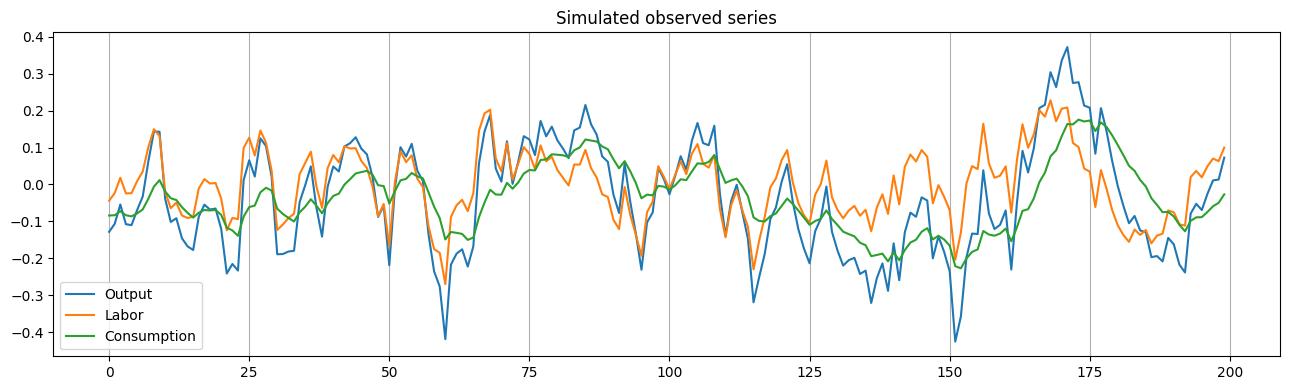

In [15]:
fig, ax = plt.subplots(figsize=(13,4))

ax.plot(sim_observed[:,0], label='Output')
ax.plot(sim_observed[:,1], label='Labor')
ax.plot(sim_observed[:,2], label='Consumption')

ax.set_title('Simulated observed series')
ax.xaxis.grid()
ax.legend(loc='lower left')

fig.tight_layout();

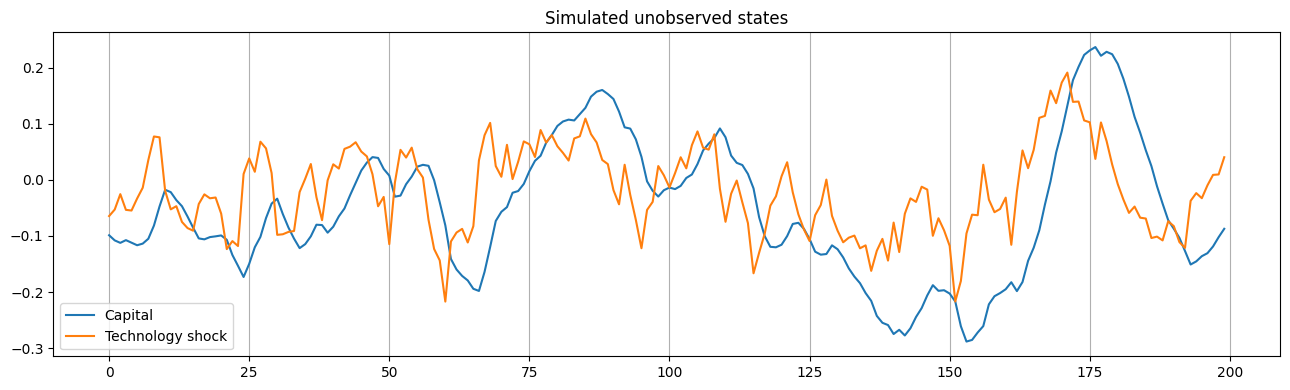

In [16]:
fig, ax = plt.subplots(figsize=(13,4))

ax.plot(sim_state[:,0], label='Capital')
ax.plot(sim_state[:,1], label='Technology shock')

ax.set_title('Simulated unobserved states')
ax.xaxis.grid()
ax.legend(loc='lower left')

fig.tight_layout();

### Observed economic data

We use data on hours worked, consumption, and investment. This is the most useful bit for interpretation.

In [17]:
# Get some FRED data
start='1984-01'
end = '2015-01'
labor = DataReader('HOANBS', 'fred', start=start, end=end)        # hours
consumption = DataReader('PCECC96', 'fred', start=start, end=end) # billions of dollars
investment = DataReader('GPDI', 'fred', start=start, end=end)     # billions of dollars
population = DataReader('CNP16OV', 'fred', start=start, end=end)  # thousands of persons
recessions = DataReader('USRECQ', 'fred', start=start, end=end)

# Collect the raw values
raw = pd.concat((labor, consumption, investment, population.resample('QS').mean()), axis=1)
raw.columns = ['labor', 'consumption', 'investment', 'population']
raw['output'] = raw['consumption'] + raw['investment']

# Make the data consistent with the model
y = np.log(raw.output * 10**(9-3) / raw.population)
n = np.log(raw.labor * (1e3 * 40) / raw.population)
c = np.log(raw.consumption * 10**(9-3) / raw.population)

# Make the data stationary
y = y.diff()[1:]
n = n.diff()[1:]
c = c.diff()[1:]

# Construct the final dataset
econ_observed = pd.concat((y, n, c), axis=1)
econ_observed.columns = ['output','labor','consumption']

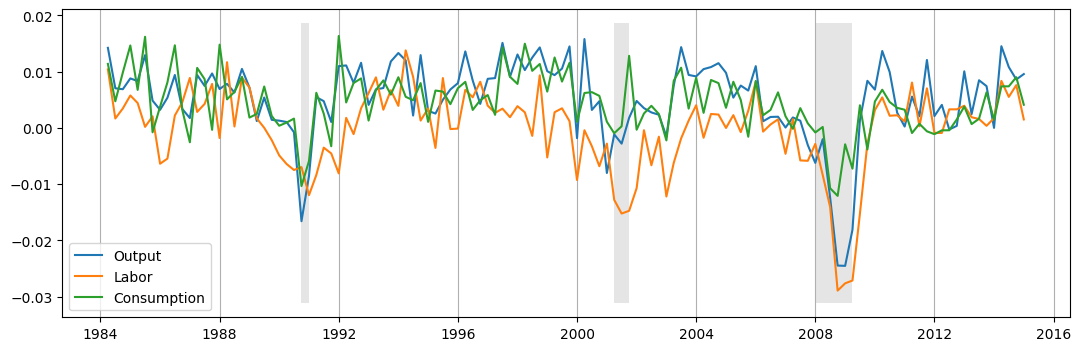

In [18]:
fig, ax = plt.subplots(figsize=(13,4))

dates = econ_observed.index._mpl_repr()

ax.plot(dates, econ_observed.output, label='Output')
ax.plot(dates, econ_observed.labor, label='Labor')
ax.plot(dates, econ_observed.consumption, label='Consumption')

rec = recessions.resample('QS').last().loc[econ_observed.index[0]:].iloc[:, 0].values
ylim = ax.get_ylim()
ax.fill_between(dates, ylim[0]+1e-5, ylim[1]-1e-5, rec, facecolor='k', alpha=0.1)

ax.xaxis.grid()
ax.legend(loc='lower left');

## Estimation

In [19]:
class EstimateRBC1(sm.tsa.statespace.MLEModel):
    def __init__(self, output=None, labor=None, consumption=None,
                 measurement_errors=True,
                 disutility_labor=3, depreciation_rate=0.025,
                 capital_share=0.36, **kwargs):

        # Determine provided observed variables
        self.output = output is not None
        self.labor = labor is not None
        self.consumption = consumption is not None
        self.observed_mask = (
            np.array([self.output, self.labor, self.consumption], dtype=bool)
        )
        
        observed_variables = np.r_[['output', 'labor', 'consumption']]
        self.observed_variables = observed_variables[self.observed_mask]
        
        self.measurement_errors = measurement_errors
        
        # Construct the full endogenous array
        endog = []
        if self.output:
            endog.append(np.array(output))
        if self.labor:
            endog.append(np.array(labor))
        if self.consumption:
            endog.append(np.array(consumption))
        endog = np.c_[endog].transpose()
        
        # Initialize the statespace model
        super(EstimateRBC1, self).__init__(endog, k_states=2, k_posdef=1, **kwargs)
        self.initialize_stationary()
        self.data.ynames = self.observed_variables
        
        # Check for stochastic singularity
        if self.k_endog > 1 and not measurement_errors:
            raise ValueError('Stochastic singularity encountered')
        
        # Save the calibrated parameters
        self.disutility_labor = disutility_labor
        self.depreciation_rate = depreciation_rate
        self.capital_share = capital_share
        
        # Create the structural model
        self.structural = ReducedRBC2()
        
        # Setup fixed elements of the statespace matrices
        self['selection', 1, 0] = 1
        
        idx = np.diag_indices(self.k_endog)
        self._idx_obs_cov = ('obs_cov', idx[0], idx[1])
        
    @property
    def start_params(self):
        start_params = [0.99, 0.5, 0.01]
        if self.measurement_errors:
            start_meas_error = np.r_[[0.1]*3]
            start_params += start_meas_error[self.observed_mask].tolist()
        
        return start_params

    @property
    def param_names(self):
        param_names = ['beta', 'rho', 'sigma.vareps']
        if self.measurement_errors:
            meas_error_names = np.r_[['sigma2.y', 'sigma2.n', 'sigma2.c']]
            param_names += meas_error_names[self.observed_mask].tolist()
        
        return param_names
    
    def transform_params(self, unconstrained):
        constrained = np.zeros(unconstrained.shape, unconstrained.dtype)
        
        # Discount rate is between 0 and 1
        constrained[0] = max(1 / (1 + np.exp(unconstrained[0])) - 1e-4, 1e-4)
        # Technology shock persistence is between -1 and 1
        constrained[1] = unconstrained[1] / (1 + np.abs(unconstrained[1]))
        # Technology shock std. dev. is positive
        constrained[2] = np.abs(unconstrained[2])
        # Measurement error variances must be positive
        if self.measurement_errors:
            constrained[3:3+self.k_endog] = unconstrained[3:3+self.k_endog]**2
        
        return constrained
    
    def untransform_params(self, constrained):
        unconstrained = np.zeros(constrained.shape, constrained.dtype)
        
        # Discount rate is between 0 and 1
        unconstrained[0] = np.log((1 - constrained[0] + 1e-4) / (constrained[0] + 1e-4))
        # Technology shock persistence is between -1 and 1
        unconstrained[1] = constrained[1] / (1 + constrained[1])
        # Technology shock std. dev. is positive
        unconstrained[2] = constrained[2]
        # Measurement error variances must be positive
        if self.measurement_errors:
            unconstrained[3:3+self.k_endog] = constrained[3:3+self.k_endog]**0.5
        
        return unconstrained
    
    def update(self, params, **kwargs):
        params = super(EstimateRBC1, self).update(params, **kwargs)
        
        # Get the parameters of the structural model
        # Note: we are calibrating three parameters
        structural_params = np.r_[
            params[0],
            self.disutility_labor,
            self.depreciation_rate,
            self.capital_share,
            params[1:3]
        ]
        
        # Solve the model
        design, transition = self.structural.solve(structural_params)
        
        # Update the statespace representation
        self['design'] = design[self.observed_mask, :]
        if self.measurement_errors:
            self[self._idx_obs_cov] = params[3:3+self.k_endog]
        self['transition'] = transition
        self['state_cov', 0, 0] = self.structural.technology_shock_std**2

### Estimation on simulated data

In [20]:
# Setup the statespace model
sim_mod = EstimateRBC1(
    output=sim_observed[:,0],
    labor=sim_observed[:,1],
    consumption=sim_observed[:,2],
    measurement_errors=True
)

# sim_res = sim_mod.fit(maxiter=1000, information_matrix_type='oim')
sim_res = sim_mod.fit(maxiter=1000)

print(sim_res.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['output' 'labor' 'consumption']   No. Observations:                  200
Model:                                 EstimateRBC1   Log Likelihood                3236.232
Date:                              Tue, 18 Nov 2025   AIC                          -6460.465
Time:                                      21:39:03   BIC                          -6440.675
Sample:                                           0   HQIC                         -6452.456
                                              - 200                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
beta             0.9500   1.03e-05    9.2e+04      0.000       0.950       0.950
rho          

/opt/anaconda3/envs/DemARK/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Estimation on observed data

In [21]:
# Setup the statespace model
econ_mod = EstimateRBC1(
    output=econ_observed['output'],
    labor=econ_observed['labor'],
    consumption=econ_observed['consumption'],
    measurement_errors=True,
    dates=econ_observed.index
)

econ_res = econ_mod.fit(maxiter=1000, information_matrix_type='oim')

print(econ_res.summary())

/opt/anaconda3/envs/DemARK/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DemARK/lib/python3.10/site-packages/statsmodels/base/optimizer.py:21: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: information_matrix_type. After release 0.14, this will raise.
  warnings.warn(


                                  Statespace Model Results                                  
Dep. Variable:     ['output' 'labor' 'consumption']   No. Observations:                  124
Model:                                 EstimateRBC1   Log Likelihood                1445.651
Date:                              Tue, 18 Nov 2025   AIC                          -2879.301
Time:                                      21:39:04   BIC                          -2862.380
Sample:                                  04-01-1984   HQIC                         -2872.427
                                       - 01-01-2015                                         
Covariance Type:                                opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
beta             0.9847      0.011     91.107      0.000       0.964       1.006
rho          

Observed data throws up variation in labor of nearly 5 units (Z), whereas simulated data throws up with calibrated parameters a 
value of 0.002, in support of the observations we made earlier above.

## References

    [1] Chris Caroll's Lecture Notes
    [2] DeJong, David N., and Chetan Dave. 2011.
        Structural Macroeconometrics. Second edition.
        Princeton: Princeton University Press.
    [3] Ruge-Murcia, Francisco J. 2007.
        "Methods to Estimate Dynamic Stochastic General Equilibrium Models."
        Journal of Economic Dynamics and Control 31 (8): 2599–2636.
